<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  The presentation below largely follows part I in "Finite Difference Methods for Ordinary and Partial Differential Equations" by LeVeque (SIAM, 2007).

In [1]:
%matplotlib inline
%precision 16
import numpy
import matplotlib.pyplot as plt

/Users/liang/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Solving Boundary Value Problems

## The Problem

We want to solve an ODE (PDE) that instead of having initial conditions is contained to an interval and has values at the edges of the interval.  This naturally comes about when we consider spatial problems.  One of the simplest cases for this is the Poisson problem in one-dimension

$$
    u_{xx} = f(x)
$$

where we will use the short-hand
$$
    u_{xx} = \frac{\text{d}^2 u}{\text{d} x^2} ~~~~ \text{or} ~~~~ \frac{\partial^2 u}{\partial x^2}.
$$

Note that due to the order of the derivative we require two conditions to solve this.  The simplest case where we are on the domain $x \in [a,b]$ is to have conditions such that we require $u(a) = u_a$ and $u(b) = u_b$ and are commonly termed boundary value problems (BVP).  If these conditions are both at one end of the domain then we can actually phrase the ODE (PDE) again as an initial value problem (IVP).  So what do we need to do to solve these types of problems?  We will consider two approaches to this problem:

1. Rephrase the BVP to an IVP and use our standard methods for ODEs.
1. Use finite differences to represent the unknowns as a linear system and solve the resulting system.

## The Shooting Method

The shooting method takes the approach that we want to use our ability to solve IVP problems and so tries to term the problem as a root finding problem for the higher order initial condition that we are not given.  This is best illustrated in an example.

Consider the problem
$$
    u_{xx} = -\sin u
$$
with
$$
    x \in [0, 2] ~~~ \text{and} ~~~ u(0) = 0.0, ~~ u(2.0) = \frac{\pi}{2}.
$$

We can rewrite this problem as a system of two ODEs as
$$
    v = \begin{bmatrix} u \\ u_x \end{bmatrix} ~~~ \text{and} ~~~ v_x = \begin{bmatrix} u_x \\ u_{xx} \end{bmatrix} = \begin{bmatrix} v_2 \\ -\sin v_1 \end{bmatrix}.
$$

We know that we want $v_1(0) = 0$ but what do we use for $v_2(0)$?  Making an initial guess at $v_2(0)$ and solving the associated IVP ODE we can then find out what these initial conditions produces on the right boundary of the problem.  Using a root-finding approach (or minimization routine) we can write this procedure as

$$
    \min_{v_2(0)} \left | \pi / 2 - v_1(2) \right |
$$

where the parameter we vary is $v_2(0)$.

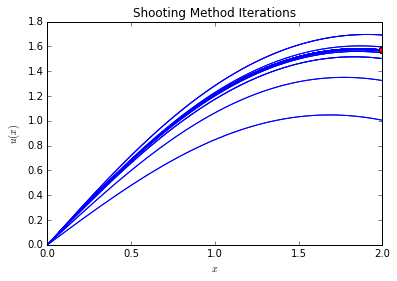

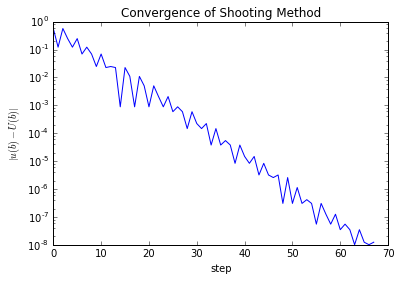

In [2]:
# Basic Shooting Method solving u_xx = -sin(u)
import scipy.integrate as integrate

# Algorithm parameters
TOLERANCE = 1e-8
MAX_ITERATIONS = 100

# Problem Statement
a = 0.0
b = 2.0
N = 100
x = numpy.linspace(a, b, N)
u_a = 0.0
u_b = numpy.pi / 2.0
# RHS function
def f(x, u):
    return numpy.array([u[1], -numpy.sin(u[0])])

# Initial guess
# Slope at RHS
u_prime_rhs = 1.0
# Initial step size
du_prime = 0.5

# Plotting
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)

# Main loop
success = False
u = numpy.empty((2, N))
convergence = numpy.zeros(MAX_ITERATIONS)
for n in xrange(MAX_ITERATIONS):
    
    # Initial condition
    u[0, 0] = u_a
    u[1, 0] = u_prime_rhs

    # Construct integrator
    integrator = integrate.ode(f)
    integrator.set_integrator("dopri5")
    integrator.set_initial_value(u[:, 0])

    # Compute solution - note that we are only producing the intermediate values
    # for demonstration purposes
    for (i, x_output) in enumerate(x[1:]):
        integrator.integrate(x_output)
        if not integrator.successful():
            raise Exception("Integration Failed!")
        u[:, i + 1] = integrator.y

    # Stopping Criteria
    convergence[n] = numpy.abs(u[0, -1] - u_b)
    if numpy.abs(u[0, -1] - u_b) < TOLERANCE:
        success = True
        break
    else:
        if u[0, -1] < u_b:
            u_prime_rhs += du_prime
        else:
            u_prime_rhs -= du_prime
            du_prime *= 0.5

    axes.plot(x, u[0, :], 'b')
    axes.plot(b, u_b, 'ro')

axes.set_title("Shooting Method Iterations")
axes.set_xlabel("$x$")
axes.set_ylabel("$u(x)$")

fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
n_range = numpy.arange(n)
axes.semilogy(n_range, convergence[:n])
axes.set_title("Convergence of Shooting Method")
axes.set_xlabel("step")
axes.set_ylabel("$|u(b) - U(b)|$")

plt.show()

The tricky part of this procedure is coming up with the search criteria, i.e. coming up with the decision of how to change $v_2(0)$ with respect to the position of $v_1(2)$ compared to what we want $u(2)$.

In general any minimization routine can be used to perform this type of approach to BVP.  These approaches are generally very effective at approaching non-linear BVPs where the next method we will discuss is too expensive to perform.

## Linear System Approach

### Formulation

The second approach we will consider involves the formation of a system of equations to solve based on finite difference approximations.  Again let's consider an example problem where
$$
    u_{xx} = f(x)
$$
with the initial conditions $u(a) = u_a$ and $u(b) = u_b$.  

We know from our finite difference discussion that the second order centered difference approximation for the second derivative for a function $u(x)$ is

$$
    u_{xx} \approx \frac{u(x_{i-1}) - 2 u(x_i) + u(x_{i+1})}{\Delta x^2}.
$$

If we discretize the domain of the original BVP into $N$ points (not including the boundaries) such that

$$
    x_i = a + \frac{b - a}{N+1} \cdot i ~~~ \text{where} ~~~ i = 1, \ldots, N
$$

we can then write the finite difference approximation as a system of linear equations!  

If for instance we take $N = 5$ then
$$\begin{aligned}
    (U_{xx})_1 &\approx \frac{U_a - 2 U_1 + U_2}{\Delta x^2} \\
    (U_{xx})_2 &\approx \frac{U_1 - 2 U_2 + U_3}{\Delta x^2} \\
    (U_{xx})_3 &\approx \frac{U_2 - 2 U_3 + U_4}{\Delta x^2} \\
    (U_{xx})_4 &\approx \frac{U_3 - 2 U_4 + U_5}{\Delta x^2} \\
    (U_{xx})_5 &\approx \frac{U_4 - 2 U_5 + U_b}{\Delta x^2} \\
\end{aligned}$$
where we have used $U_a = u(a)$ and $U_b = u(b)$ as the boundary conditions.  

Using these approximations to the derivatives we can then write the ODE as

$$
    \frac{1}{\Delta x^2}\begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) \\
    \end{bmatrix}.
$$

Note that our previous example used for the shooting method is difficult in the current context as the unknown function is in the function $f$ so that we would need to actually solve a non-linear system of equations.  This is still possible in this context using an approach such as a Newton solver and has similar properties as the shooting method (although not as simple to implement).

### Boundary Conditions

This does not include the boundary conditions though.  We can add these values easily for Dirichlet boundary conditions by sending the values we know to the $b$ vector:

$$\begin{aligned}
    \frac{U_a - 2 U_1 + U_2}{\Delta x^2} = f(x_1) &\Rightarrow& \frac{- 2 U_1 + U_2}{\Delta x^2} = f(x_1) - \frac{U_a}{\Delta x^2} \\
    \frac{U_4 - 2 U_5 + U_b}{\Delta x^2} = f(x_1) &\Rightarrow& \frac{U_4 - 2 U_5}{\Delta x^2} = f(x_5) - \frac{U_b}{\Delta x^2}
\end{aligned}$$

so that final system looks like

$$
    \frac{1}{\Delta x^2} \begin{bmatrix}
    -2 &  1 &    &    &    \\
     1 & -2 &  1 &    &    \\
       &  1 & -2 &  1 &    \\
       &    &  1 & -2 &  1 \\
       &    &    &  1 & -2 \\
    \end{bmatrix} \begin{bmatrix}
        U_1 \\ U_2 \\ U_3 \\ U_4 \\ U_5
    \end{bmatrix} = 
    \begin{bmatrix}
        f(x_1) - \frac{U_a}{\Delta x^2} \\ f(x_2) \\ f(x_3) \\ f(x_4) \\ f(x_5) - \frac{U_b}{\Delta x^2} \\
    \end{bmatrix}.
$$

### Example

Want to solve the BVP

$$
    u_{xx} = e^x, ~~~~ x \in [0, 1] ~~~~ \text{with} ~~~~ u(0) = 0.0, \text{ and } u(1) = 3
$$

via the construction of a linear system of equations.

\begin{align*}
    u_{xx} &= e^x \\
    u_x &= A + e^x \\
    u &= Ax + B + e^x\\
    u(0) &= B + 1 = 0 \Rightarrow B = -1 \\
    u(1) &= A - 1 + e^{1} = 3 \Rightarrow A = 4 - e\\ 
    ~\\
    u(x) &= (4 - e) x - 1 + e^x
\end{align*}

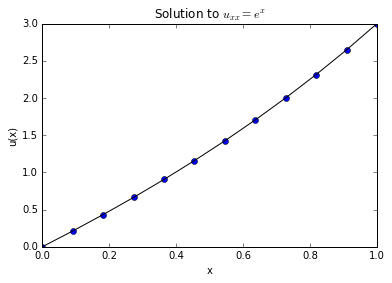

In [3]:
# Problem setup
a = 0.0
b = 1.0
u_a = 0.0
u_b = 3.0
f = lambda x: numpy.exp(x)
u_true = lambda x: (4.0 - numpy.exp(1.0)) * x - 1.0 + numpy.exp(x)

# Descretization
N = 10
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N, N))
diagonal = numpy.ones(N) / delta_x**2
A += numpy.diag(diagonal * -2.0, 0)
A += numpy.diag(diagonal[:-1], 1)
A += numpy.diag(diagonal[:-1], -1)

# Construct RHS
b = f(x)
b[0] -= u_a / delta_x**2
b[-1] -= u_b / delta_x**2

# Solve system
U = numpy.empty(N + 2)
U[0] = u_a
U[-1] = u_b
U[1:-1] = numpy.linalg.solve(A, b)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
plt.show()

If we instead have Neumann boundary conditions it is no longer clear how to handle the boundary conditions using the above approach.  Instead a **ghost cell** approach is often used.  These **ghost cells** are added unknowns that represent the boundary values that we actually know.  

For instance, if we had the BVP

$$
    u_{xx} = e^x, ~~~~ x \in [-1, 1] ~~~~ \text{with} ~~~~ u(-1) = 3, \text{ and } u_x(1) = -5
$$

then we could keep the boundary values in the vector of unknowns so that now

$$
    U = \begin{bmatrix} U_0 \\ U_1 \\ \vdots \\ U_N \\ U_{N+1} \end{bmatrix}
$$

where here $U_0$ and $U_{N+1}$ are actually the boundary points.  

The matrix $A$ is then modified to have the appropriate relationships.  In this case the left boundary condition leads to

$$
    A = \begin{bmatrix}
  1 &    &    &    &    &    \\
  \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    &    \\
    &  \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    \\
    & & \ddots & \ddots & \ddots
    \end{bmatrix} ~~~~ \text{and} ~~~~ b = \begin{bmatrix}
        u(a) \\ f(x_1) \\ f(x_2) \\ \vdots
    \end{bmatrix}
$$

which multiplied out simply gives

$$
    U_0 = u(-1) = 3.
$$

For the right boundary condition we can use the second order backward finite difference approximation for the first derivative

$$
    u_x(b) \approx \frac{3 U_{N+1} - 4 U_{N} + U_{N - 1}}{2.0 \Delta x} = -5
$$

which can be incorporated into the matrix $A$ and vector $b$ as

$$
    A =  \begin{bmatrix}
     \ddots & \ddots & \ddots &    &    \\
            & \frac{1}{\Delta x^2} &     \frac{-2}{\Delta x^2}&  \frac{1}{\Delta x^2} &    \\
            &        &      \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} \\
            &        &      \frac{1}{2 \Delta x} &  \frac{-4}{2 \Delta x} &  \frac{3}{2 \Delta x} \\
    \end{bmatrix} ~~~~ \text{and} ~~~~ b = \begin{bmatrix}
        \vdots \\ f(x_N) \\ u_x(b)
    \end{bmatrix}.
$$

All together the new system looks like

$$
    \begin{bmatrix}
     1 &    &    &    &    &    \\
     \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} &    &    &    \\
       &  \ddots & \ddots &  \ddots &    \\
       &    & \frac{1}{\Delta x^2} & \frac{-2}{\Delta x^2} &  \frac{1}{\Delta x^2} \\
            &        &      \frac{1}{2 \Delta x} &  \frac{-4}{2 \Delta x} &  \frac{3}{2 \Delta x} \\
    \end{bmatrix} \begin{bmatrix}
        U_0 \\ U_1 \\ \vdots \\ U_N \\ U_{N+1}
    \end{bmatrix} = 
    \begin{bmatrix}
        u(a) \\ f(x_1) \\ \vdots \\ f(x_N) \\ u_x(b)
    \end{bmatrix}.
$$

### Example

Want to solve the BVP

$$
    u_{xx} = e^x, ~~~~ x \in [-1, 1] ~~~~ \text{with} ~~~~ u(-1) = 3.0, \text{ and } u_x(1) = -5.0
$$

via the construction of a linear system of equations.

First find the true solution and then compute the solution.

\begin{align*}
    u(x) &= A x + B + e^x \\
    u_x(1) &= A + e^1 = -5 \Rightarrow A = -5 - e \\
    u(-1) &= (5 + e) + B + e^{-1} = 3 \Rightarrow B = 3 - 5 - e - e^{-1} = -(2 + e + e^{-1}) \\
    ~\\
    u(x) &= -(5 + e) x -(2 + e + e^{-1}) + e^{x}
\end{align*}

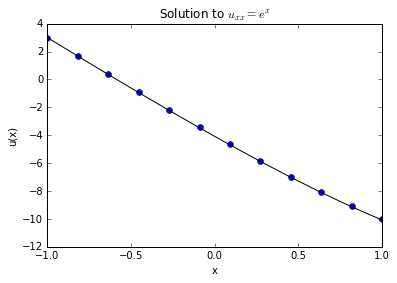

In [4]:
# Problem setup
a = -1.0
b = 1.0
u_a = 3.0
u_x_b = -5.0
f = lambda x: numpy.exp(x)
u_true = lambda x: -(5.0 + numpy.exp(1.0)) * x - (2.0 + numpy.exp(1.0) + numpy.exp(-1.0)) + numpy.exp(x)

# Descretization
N = 10
x_bc = numpy.linspace(a, b, N + 2)
x = x_bc[1:-1]
delta_x = (b - a) / (N + 1)

# Construct matrix A
A = numpy.zeros((N + 2, N + 2))
diagonal = numpy.ones(N + 2) / delta_x**2
A += numpy.diag(diagonal * -2.0, 0)
A += numpy.diag(diagonal[:-1], 1)
A += numpy.diag(diagonal[:-1], -1)

# Construct RHS
b = f(x_bc)

# Boundary conditions
A[0, 0] = 1.0
A[0, 1] = 0.0
A[-1, -1] = 3.0 / (2.0 * delta_x)
A[-1, -2] = -4.0 / (2.0 * delta_x)
A[-1, -3] = 1.0 / (2.0 * delta_x)

b[0] = u_a
b[-1] = u_x_b

# Solve system
U = numpy.empty(N + 2)
U = numpy.linalg.solve(A, b)

# Plot result
fig = plt.figure()
axes = fig.add_subplot(1, 1, 1)
axes.plot(x_bc, U, 'o', label="Computed")
axes.plot(x_bc, u_true(x_bc), 'k', label="True")
axes.set_title("Solution to $u_{xx} = e^x$")
axes.set_xlabel("x")
axes.set_ylabel("u(x)")
plt.show()

### Ways to Solve $A u = f$

We have proposed solving the linear system $A u = f$ which we have implemented naively above with the `numpy.linalg.solve` command but perhaps given the special structure of $A$ here that we can do better.   

#### Direct Methods (Gaussian Elimination)

We could use Gaussian elimination to solve the system (or some factorization) which leads to a solution in a finite number of steps.  For large, sparse methods however these direct solvers are much more expensive in general over iterative solvers.  As was discussed for eigenproblems, iterative solvers start with an initial guess and try to improve on that guess. 

Consider a problem in 3D (say the Poisson problem) which is descretized in each direction with 100 points leading to $10^6$ unknowns all together.  It can be shown that Gaussian elimination requires $\mathcal{O}(N^3)$ operations to complete in general meaning we would need to perform $10^{18}$ floating point operations to complete the solve.  On a reasonable personal computer we can compute at about 100 gigaflops (floating point operations per second) or about $10^{11}$ floating point operations per second.  This means that if you were to solve this problem (which is actually fairly modest) you would have to wait approximately 115 days for your machine to finish.  Using an alternative method we can solve this problem in seconds.

As has been mentioned, memory is also an issue.  If we tried to store the entire matrix needed above we would need $N^2$ memory locations.  Even in single precision floating point storage we would require 4-bytes per number leading to $4 \times 10^{12}$ bytes or 4 terabytes of memory.

The situation really is not as bad as we are making it out to be as long as we take advantage of the sparse nature of the matrices.  In fact for 1 dimensional problems direct methods can be reduced to $\mathcal{O}(N)$ in the case for a tridiagonal system.  The situation is not so great for higher-dimensional problems however unless most structure can be leveraged.  Examples of these types of solvers include fast Fourier methods such as fast Poisson solvers.

#### Iterative Methods

Iterative methods take another tact that direct methods.  If we have the system $A x = b$ we form an iterative procedure that applies a function, say $L$, such that

$$
    \hat{x}^{(k)} = L(\hat{x}^{(k-1)})
$$

where we want the error between the real solution $x$ and $\hat{x}^{(k)}$ to go to zero as $k \rightarrow \infty$.  We will explore these methods in the next lecture.